# Adoption Model

This is the code used in the tutorial paper: Onggo BSS, Foramitti J (in press). Agent-Based Modeling and Simulation for Management Decisions: A Review and Tutorial. In Proceedings of the 2021 Winter Simulation Conference, pp.

The model represents a market with a finite number of consumers for a product (i.e. no competition). Initially, all consumers are non-adopters. A consumer can become an adopter when it receives an advertisement that is broadcasted to all agents in each time step, or when the consumer receives word-of-mouth (WOM) messages from its neighbors. Once a consumer becomes an adopter, it will stay as an adopter until the simulation ends. The objective of the model is to estimate the impact of WOM and advertisement on product sales. This example is taken from Grigoryev (2018) “AnyLogic in Three Days: Modeling and Simulation Textbook” https://www.anylogic.com/resources/books/free-simulation-book-and-modeling-tutorials/.

if you have not installed agentpy, you need to install it first (you only need to do this once)

In [ ]:
!pip install agentpy

Import libraries that will be used in the model.

In [11]:
import agentpy as ap 
import networkx as nx
import random
import seaborn as sns
import matplotlib.pyplot as plt

## Agent definition

This is where we define consumer agent type. In agentpy, we need to override setup() which is the constructor of the agent type. In the setup(), we define the agent's properties: 
1. ad_effectiveness: the probability of the agent will become user when receiving an advertisement message
2. adoption_fraction: the probability of the agent will become user when receiving a word of mouth (WOM) message
3. contact_rate: applicable to user only. This is the frequency of WOM message sent each timestep.
4. become_adopter: if true, the consumer will become a use in the next timestep
5. is_user: true if the consumer is a user

In [12]:
class ConsumerAgent(ap.Agent):
    def setup(self):
        self.ad_effectiveness = 0.01
        self.adoption_fraction = 0.01
        self.contact_rate = 1
        self.become_adopter = False
        self.is_adopter = False
        
    def get_neighbors(self):
        self.neighbors = self.network.neighbors(self).to_list()
        
    def step(self):
        if self.is_adopter: 
            for _ in range(self.contact_rate):
                partner = self.neighbors.random()
                if not partner.is_adopter:
                    partner.adopt(probability=partner.adoption_fraction)
        else:
            self.adopt(probability=self.ad_effectiveness)
            
    def adopt(self, probability):
        rng = self.model.random
        if rng.random() < probability:
            self.become_adopter = True
            
    def update(self):
        if self.become_adopter:
            self.is_adopter = True
            self.become_adopter = False
            self.model.n_adopters += 1

## Model definition

we need to define the ABM by overriding four methods: setup, step, and update and end. When a simulation is started, it will call method setup(). This is where we add agents and environment into the model. The method step() is used to define what agents will do in each time step. In this model, all agents will run their step() method. The method update() is called after the methods setup() and step() are completed. If needed, we can override method end() which will be executed when the simulation ends. In this model, we ask all agents to record their final state.

In [13]:
class MarketModel(ap.Model):
    def setup(self):
        graph = nx.watts_strogatz_graph(
            self.p.n_agents, 
            self.p.n_neighbors, 
            self.p.network_randomness)
        
        self.n_adopters = 0
        self.agents = ap.AgentList(self, self.p.n_agents, ConsumerAgent)
        self.network = self.agents.network = ap.Network(self, graph=graph)
        self.network.add_agents(self.agents, self.network.nodes)
        self.agents.get_neighbors()
        
    def step(self):
        self.agents.step()

    def update(self):
        self.agents.update()
        self.record('n_adopters')
        
    def end(self):
        self.agents.record('is_adopter')

## Parameters

In [14]:
parameters = {
    'seed': 1,
    'steps': 300,
    'n_agents': 1000,
    'n_neighbors': 2,
    'network_randomness': 0.5,
}

## Single run

Completed: 300 steps
Run time: 0:00:04.580017
Simulation finished


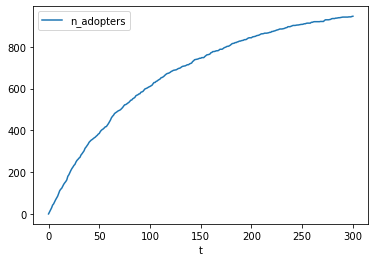

In [15]:
model = MarketModel(parameters)
results = model.run()
data = results.variables.MarketModel
ax = data.plot()

## Multiple runs

Scheduled runs: 10
Completed: 10, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:00:26.974094


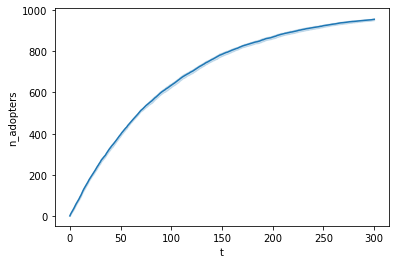

In [16]:
exp = ap.Experiment(MarketModel, parameters, record=True, iterations=10)
results = exp.run()
data = results.arrange_variables()
ax = sns.lineplot(data=data, x='t', y='n_adopters')